In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [3]:
df = pd.read_csv('dataCarSale2021-2025.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2021-01-01 to 2025-07-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DAIHATSU    54 non-null     float64
 1   HONDA       54 non-null     float64
 2   MITSUBISHI  54 non-null     float64
 3   SUZUKI      54 non-null     float64
 4   TOYOTA      54 non-null     float64
dtypes: float64(5)
memory usage: 2.5 KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA
count     54.000000     54.000000     54.000000     54.000000     54.000000
mean   11254.531630   7645.139556   8760.141000   5609.579630  19934.127907
std     4597.871605   3886.261244   3351.676613   2351.526395   7855.556087
min     5755.232000   1590.411000   4349.666000   2004.813000   7617.122000
25%     7477.087250   3855.075250   6204.000000   3227.915000  12472.187250
50%     9310.389000   7725.500000   7637.046000   5830.500000  20983.500000
75%    15638.000000

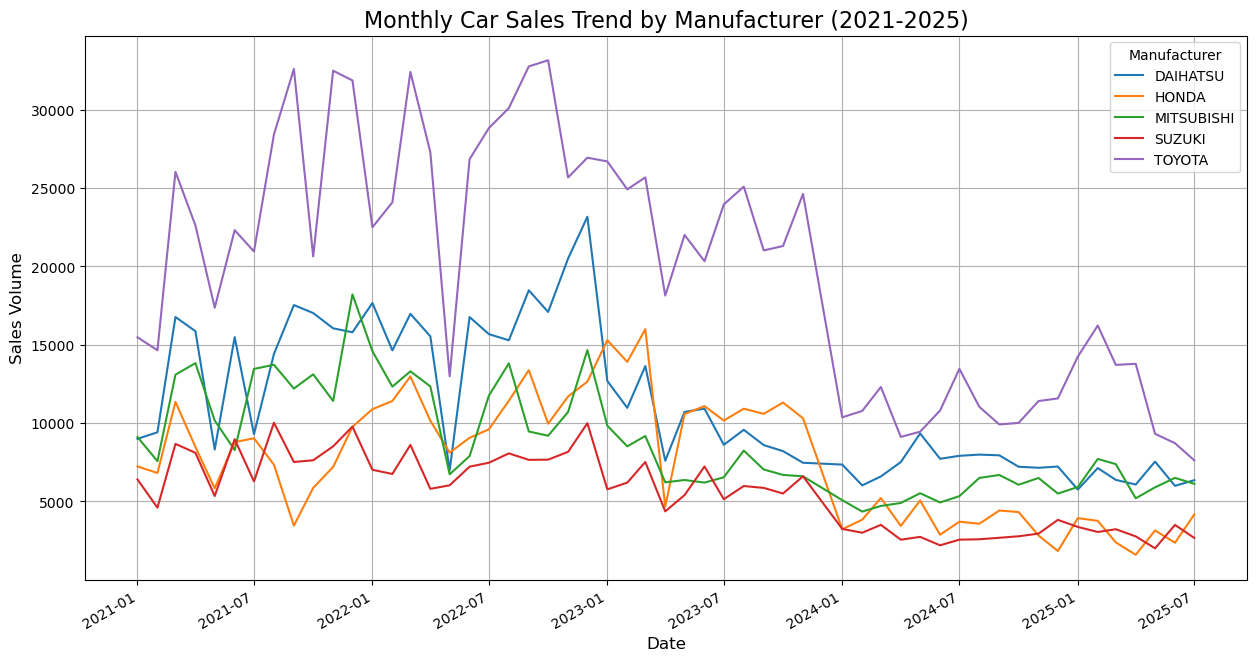

In [4]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [5]:
# Calculate total sales to use as the target variable
df['TOTAL_SALES'] = df.sum(axis=1)

def create_features(df):
    """Function to create time-series features from a datetime index."""
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    return df

df = create_features(df)

# Define features and the target
FEATURES = ['year', 'month', 'quarter', 'dayofyear', 'weekofyear']
TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

for brand in TARGETS:
    df[f'{brand}_lag1'] = df[brand].shift(1)
    df[f'{brand}_lag3'] = df[brand].shift(3)
    # df[f'{brand}_lag12'] = df[brand].shift(12)
    
    # 移動平均特徴量 (過去3ヶ月と12ヶ月の平均)
    df[f'{brand}_rolling_mean3'] = df[brand].shift(1).rolling(window=3).mean()
    # df[f'{brand}_rolling_mean12'] = df[brand].shift(1).rolling(window=12).mean()
    
    # 移動標準偏差 (過去3ヶ月)
    df[f'{brand}_rolling_std3'] = df[brand].shift(1).rolling(window=3).std()
df = df.dropna()

X = df[FEATURES]
y = df[TARGETS]



print(df.head(20))


            DAIHATSU    HONDA  MITSUBISHI   SUZUKI   TOYOTA  TOTAL_SALES  \
waktu                                                                      
2021-04-01   15861.0   8474.0     13820.0   8100.0  22618.0      68873.0   
2021-05-01    8310.0   5832.0     10160.0   5341.0  17361.0      47004.0   
2021-06-01   15481.0   8782.0      8277.0   8965.0  22310.0      63815.0   
2021-07-01    9284.0   9030.0     13453.0   6274.0  20950.0      58991.0   
2021-08-01   14408.0   7337.0     13720.0  10021.0  28418.0      73904.0   
2021-09-01   17529.0   3453.0     12200.0   7515.0  32596.0      73293.0   
2021-10-01   17020.0   5861.0     13109.0   7624.0  20633.0      64247.0   
2021-11-01   16045.0   7201.0     11410.0   8512.0  32487.0      75655.0   
2021-12-01   15795.0   9759.0     18211.0   9772.0  31865.0      85402.0   
2022-01-01   17660.0  10883.0     14586.0   7017.0  22493.0      72639.0   
2022-02-01   14638.0  11407.0     12323.0   6750.0  24087.0      69205.0   
2022-03-01  

In [6]:
from prophet import Prophet
import pandas as pd

# 警告を非表示にする
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 結果を保存する辞書
prophet_forecasts = {}
prophet_models = {}

for target in TARGETS:
    print(f"\nTraining Prophet model for {target}...")
    
    # 1. Prophet用のデータフレームを作成
    # 元のdfから日付(インデックス)とターゲットの売上を抽出
    df_prophet = df.reset_index()[['waktu', target]].rename(columns={'waktu': 'ds', target: 'y'})
    
    # 2. 訓練データと検証データに分割
    TRAIN_END = '2024-12-31'
    train_df = df_prophet[df_prophet['ds'] <= TRAIN_END]
    val_df = df_prophet[df_prophet['ds'] > TRAIN_END]
    
    # 3. Prophetモデルの学習
    # weekly_seasonality=False: 月次データなので週の季節性は不要
    model = Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
    model.fit(train_df)
    
    prophet_models[target] = model
    
    # 4. 予測用のデータフレームを作成
    # len(val_df)で検証期間の月数を指定
    future = model.make_future_dataframe(periods=len(val_df), freq='MS') # 'MS'は月の初日
    
    # 5. 予測を実行
    forecast = model.predict(future)
    
    prophet_forecasts[target] = forecast

    
prophet_results = []



ModuleNotFoundError: No module named 'prophet'

In [ ]:
# Define the SMAPE function
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    The result is returned as a percentage (e.g., 15.0 for 15%).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle the case where the denominator is zero.
    # If both true and predicted are 0, the error is 0.
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100


for target in TARGETS:
    # 予測結果から検証期間のデータのみを抽出
    forecast_val = prophet_forecasts[target].iloc[-len(y_val):]
    
    # SMAPEスコアを計算
    smape_score = smape(y_val[target].values, forecast_val['yhat'].values)
    
    results = {
        'Brand': target,
        'SMAPE (%)': smape_score
    }
    prophet_results.append(results)

# 結果をDataFrameで表示
df_prophet_results = pd.DataFrame(prophet_results)
print("\n--- Prophet Model Evaluation ---")
print(df_prophet_results.sort_values(by='SMAPE (%)'))


--- Model Evaluation Metrics (including SMAPE) ---
        Brand          MAE         RMSE  R-squared  SMAPE (%)
0  MITSUBISHI   711.182245   827.855154  -0.022845  11.064178
1      SUZUKI   319.106878   427.146836   0.186207  11.298597
2    DAIHATSU  1348.804136  1463.681797  -5.027676  19.496510
3      TOYOTA  2863.652070  3091.302107  -0.011004  24.776354
4       HONDA  1247.371963  1534.462842  -1.945086  37.169479


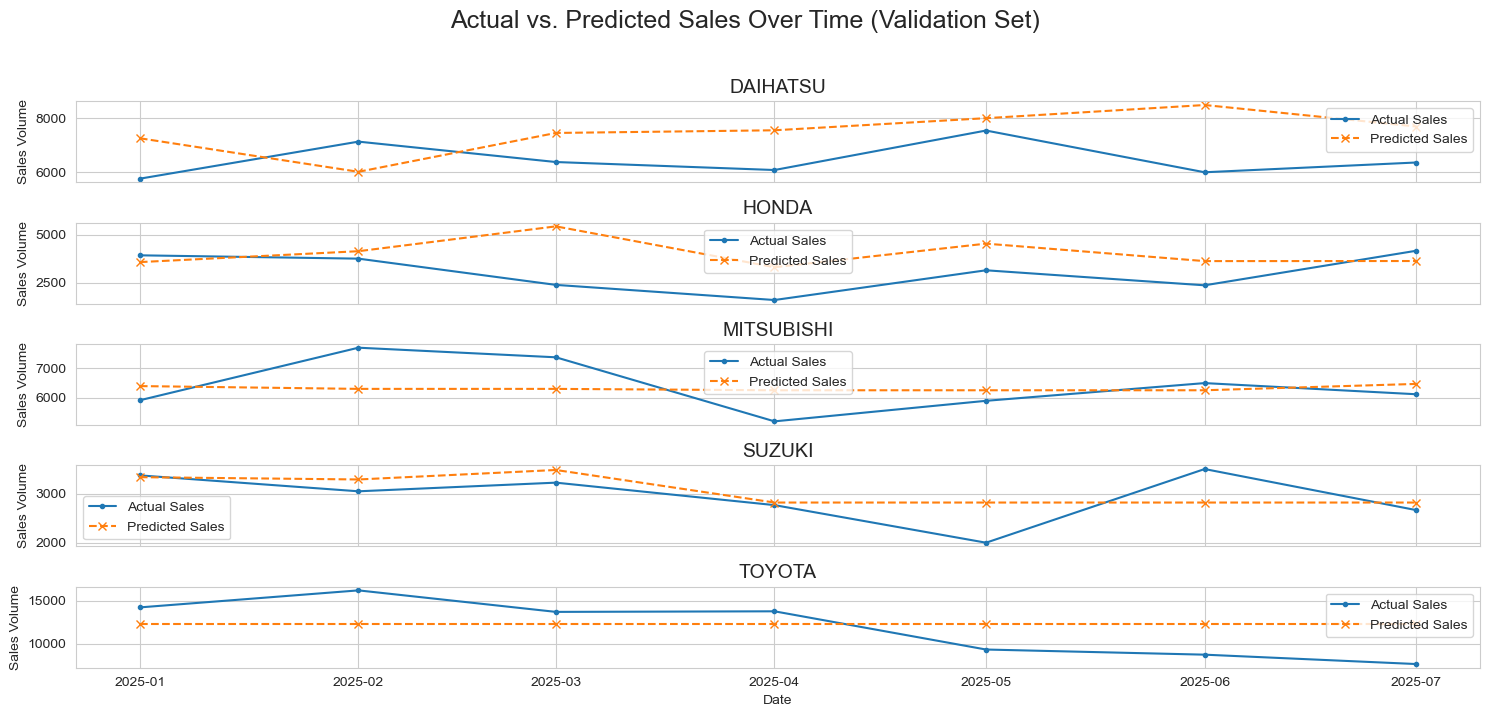

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style('whitegrid')

# Create subplots to visualize each model's predictions
# This will create a separate chart for each brand for clarity
fig, axes = plt.subplots(nrows=len(TARGETS), ncols=1, figsize = (15, 8), sharex=True)
fig.suptitle('Actual vs. Predicted Sales Over Time (Validation Set)', fontsize=18, y=0.92)

for i, target in enumerate(TARGETS):
    # Get the specific subplot
    ax = axes[i]
    
    # Use the trained model for the brand to make predictions
    y_pred = models[target].predict(X_val)
    
    # Plot the actual sales data from the validation set
    ax.plot(y_val.index, y_val[target], label='Actual Sales', marker='.', linestyle='-')
    
    # Plot the model's predicted sales on top
    ax.plot(y_val.index, y_pred, label='Predicted Sales', marker='x', linestyle='--')
    
    # Set titles and labels for clarity
    ax.set_title(target, fontsize=14)
    ax.set_ylabel('Sales Volume')
    ax.legend()

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()